In [1]:
import pandas as pd

## Data Importing and Cleaning ##

In [135]:
df = pd.read_csv('grocery_store_data_cleaned.csv')
df = df[df['PAYMENT'].isin(['cash','magcard'])]
df.rename({'DATE':'DATETIME'}, axis=1, inplace=True)
df['DATE'] = pd.to_datetime(df['DATETIME']).dt.to_period('D')
df['MONTH'] = pd.to_datetime(df['DATETIME']).dt.to_period('M')
df.head()

,Unnamed: 0,TICKET,UNITS,REFERENCE,CODE,NAME,UNIT_PRICEBUY,UNIT_PRICESELL,DATETIME,PAYMENT,TRANSID,CATEGORY,TOTAL_PRICEBUY,TOTAL_PRICESELL,UNIT_PRICE_MARGIN,PROFIT,DATE,MONTH
0,0,d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9,3.292,1079,1.079000e+03,Pumpkin Japanese/Kent,0.0,1.99,2016-03-16 23:15:39,cash,no ID,Pumpkins,0.000,6.55108,1.99,6.55108,2016-03-16,2016-03
1,1,d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9,0.290,2032,2.032000e+03,Orange navel,0.0,2.99,2016-03-16 23:15:39,cash,no ID,Citrus,0.000,0.86710,2.99,0.86710,2016-03-16,2016-03
3,3,aa299de6-1332-48ba-bce9-de8cbb48741e,3.292,1001,1.001000e+03,Australian Asparagus green,2.0,2.70,2016-03-16 23:19:47,cash,no ID,Bunch Vegies,6.584,8.88840,0.70,2.30440,2016-03-16,2016-03
4,4,aa299de6-1332-48ba-bce9-de8cbb48741e,1.000,4019,8.888101e+12,Nice Munchee 200g,0.9,1.50,2016-03-16 23:19:47,cash,no ID,Sri Lankan Groceries,0.900,1.50000,0.60,0.60000,2016-03-16,2016-03
5,5,fccc4298-a401-414a-98fc-192d4bf9735c,2.230,1001,1.001000e+03,Australian Asparagus green,2.0,2.70,2016-03-16 23:20:23,cash,no ID,Bunch Vegies,4.460,6.02100,0.70,1.56100,2016-03-16,2016-03


In [136]:
df.CATEGORY.value_counts()

Other Vegies            64901
Bananas                 43965
Potatoes                38171
Citrus                  37398
Tomatoes                34832
Onions                  34664
Apples                  31992
Bunch Vegies            25978
Stonefruits             25808
Lettuces                19275
Cucumbers               18913
capsicum                17916
Grapes                  17339
Melons                  17007
Sri Lankan Groceries    16041
Asian Vegies            15878
Pears                   15756
Herbs                   15378
Groceries-Dry Goods     14903
Pumpkins                14296
carrots                 13908
Multi buy               13859
Cut Veggies             12374
Eggs                    10970
Tropical Fruits          9764
Chillies                 9559
Mushrooms                9345
Other Fruits             8945
Berries                  7263
Avocadoes                6970
Root Vegies              6887
Olympian Products        5360
Cabbages                 3631
Fruits    

### As you can see, there are several categories, with multiple products per category. ###


### For this case, we will only use the grapes category since we observed that the grapes category has a good amount of seasonality and trend which makes the task challenging ###

In [8]:
df_temp = df[df['CATEGORY']=='Grapes']

In [145]:
df_sales_daily = df_temp[['DATE','TICKET']].groupby('DATE').count()
df_sales_daily.head()

,TICKET
DATE,
2016-03-17,65
2016-03-18,18
2016-03-19,18
2016-03-20,12
2016-03-21,18


In [146]:
df_sales_daily.shape

(1144, 1)

## Train-Test Split ##

### In our data, we are reserving the last three months (90 days) of our data for testing purposes. All the other data is used for training. ###

In [147]:
train = df_sales_daily.iloc[:-90]
test = df_sales_daily.iloc[-90:]

In [148]:
train.tail()

,TICKET
DATE,
2019-06-14,5
2019-06-15,6
2019-06-16,3
2019-06-17,9
2019-06-18,3


In [119]:
test.head()

,TICKET
DAY,
2019-06-19,4
2019-06-20,6
2019-06-21,4
2019-06-22,6
2019-06-23,3


## Modelling ##

In [151]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
 print('Results of dickey fuller test')
 adft = adfuller(timeseries, autolag='AIC')
 # output for dft will give us without defining what the values are.
 #hence we manually write what values does it explains using a for loop
 output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
 for key,values in adft[4].items():
   output['critical value (%s)'%key] = values
   print(output)
 
test_stationarity(train['TICKET'])

Results of dickey fuller test
Test Statistics                  -2.546846
p-value                           0.104488
No. of lags used                 21.000000
Number of observations used    1032.000000
critical value (1%)              -3.436702
dtype: float64
Test Statistics                  -2.546846
p-value                           0.104488
No. of lags used                 21.000000
Number of observations used    1032.000000
critical value (1%)              -3.436702
critical value (5%)              -2.864345
dtype: float64
Test Statistics                  -2.546846
p-value                           0.104488
No. of lags used                 21.000000
Number of observations used    1032.000000
critical value (1%)              -3.436702
critical value (5%)              -2.864345
critical value (10%)             -2.568263
dtype: float64


We notice that the p-value is greater than 0.05. Thus, we need to modify our calculations.

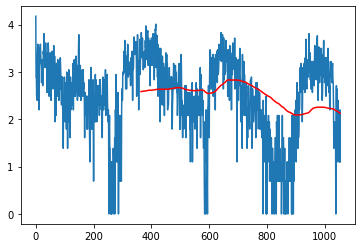

In [152]:
import numpy as np

train_log = np.log(train['TICKET']) 
test_log = np.log(test['TICKET'].values)
moving_avg = train_log.rolling(365).mean() 
plt.plot(train_log.values) 
plt.plot(moving_avg.values, color = 'red') 
plt.show()

In [153]:
train_log_moving_avg_diff = train_log - moving_avg

In [154]:
train_log_moving_avg_diff.dropna(inplace = True), test_stationarity(train_log_moving_avg_diff)

Results of dickey fuller test
Test Statistics                 -2.513637
p-value                          0.112191
No. of lags used                 6.000000
Number of observations used    683.000000
critical value (1%)             -3.439961
dtype: float64
Test Statistics                 -2.513637
p-value                          0.112191
No. of lags used                 6.000000
Number of observations used    683.000000
critical value (1%)             -3.439961
critical value (5%)             -2.865781
dtype: float64
Test Statistics                 -2.513637
p-value                          0.112191
No. of lags used                 6.000000
Number of observations used    683.000000
critical value (1%)             -3.439961
critical value (5%)             -2.865781
critical value (10%)            -2.569028
dtype: float64


(None, None)

In [155]:
train_log_diff = train_log - train_log.shift(1) 
test_stationarity(train_log_diff.dropna())

Results of dickey fuller test
Test Statistics                 -22.861827
p-value                           0.000000
No. of lags used                  5.000000
Number of observations used    1047.000000
critical value (1%)              -3.436611
dtype: float64
Test Statistics                 -22.861827
p-value                           0.000000
No. of lags used                  5.000000
Number of observations used    1047.000000
critical value (1%)              -3.436611
critical value (5%)              -2.864304
dtype: float64
Test Statistics                 -22.861827
p-value                           0.000000
No. of lags used                  5.000000
Number of observations used    1047.000000
critical value (1%)              -3.436611
critical value (5%)              -2.864304
critical value (10%)             -2.568242
dtype: float64


## Removing Seasonality ##

C:\Users\iGuest\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


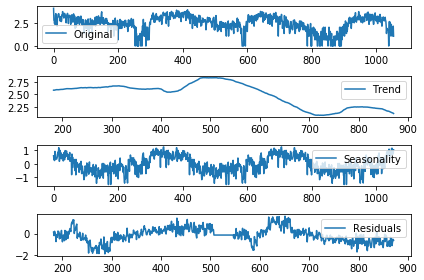

In [156]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(train_log, model='additive', freq=365)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(train_log.values, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend.values, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal.values,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual.values, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [157]:
train_log_decompose = pd.DataFrame(residual) 
train_log_decompose['date'] = train_log.index 
train_log_decompose.set_index('date', inplace = True)

In [158]:
train_log_decompose = pd.DataFrame(residual) 
train_log_decompose['date'] = train_log.index 
train_log_decompose.set_index('date', inplace = True)
train_log_decompose.dropna(inplace=True) 
test_stationarity(train_log_decompose.iloc[:,0].values)

Results of dickey fuller test
Test Statistics                 -2.554307
p-value                          0.102814
No. of lags used                12.000000
Number of observations used    677.000000
critical value (1%)             -3.440046
dtype: float64
Test Statistics                 -2.554307
p-value                          0.102814
No. of lags used                12.000000
Number of observations used    677.000000
critical value (1%)             -3.440046
critical value (5%)             -2.865819
dtype: float64
Test Statistics                 -2.554307
p-value                          0.102814
No. of lags used                12.000000
Number of observations used    677.000000
critical value (1%)             -3.440046
critical value (5%)             -2.865819
critical value (10%)            -2.569049
dtype: float64


In [ ]:
import pmdarima

# Seasonal - fit stepwise auto-ARIMA
smodel = pmdarima.auto_arima(train_log, start_p=2, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
Fit ARIMA(2,0,1)x(0,1,1,12) [intercept=True]; AIC=1534.838, BIC=1564.531, Time=20.596 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=True]; AIC=2438.185, BIC=2448.083, Time=1.464 seconds
Fit ARIMA(1,0,0)x(1,1,0,12) [intercept=True]; AIC=2026.644, BIC=2046.440, Time=5.948 seconds
Fit ARIMA(0,0,1)x(0,1,1,12) [intercept=True]; AIC=2081.333, BIC=2101.128, Time=4.389 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=False]; AIC=2436.517, BIC=2441.466, Time=0.164 seconds
Fit ARIMA(2,0,1)x(0,1,0,12) [intercept=True]; AIC=2216.523, BIC=2241.268, Time=1.898 seconds
Fit ARIMA(2,0,1)x(1,1,1,12) [intercept=True]; AIC=1532.261, BIC=1566.904, Time=23.299 seconds
Near non-invertible roots for order (2, 0, 1)(1, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(2,0,1)x(0,1,2,12) [intercept=True]; AIC=1532.379, BIC=1567.022, Time=95.413 seconds
Near non-invertible roots for order (2, 0, 1)(0, 1

In [ ]:
# Forecast
n_periods = 8
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(train_log.index[-1].to_timestamp(freq ='D'), periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)


In [ ]:
# Plot
plt.plot(train_log.to_timestamp(freq ='D'))
plt.plot(fitted_series, color='darkgreen')

In [137]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rms = sqrt(mean_squared_error(test_log,fitted_series))
print("RMSE: ", rms)

ValueError: Found input variables with inconsistent numbers of samples: [90, 8]

In [149]:
len(test_log)

90

In [ ]:
len(fitted_series)